In [15]:
#Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import yfinance as yf
import datetime
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM


In [16]:
#We are going to be looking at a 10 years timeframe
start = datetime.datetime.now() - datetime.timedelta(days=10*365)
end = datetime.datetime.now()

#Download stock data from yahoo finance
df = yf.download("AAPL", start, end)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-02-28,15.858929,15.995357,15.764286,15.764286,13.615317,322515200
2013-03-01,15.642857,15.649286,15.356429,15.373929,13.278171,552448400
2013-03-04,15.278571,15.292857,14.964286,15.001786,12.956762,582755600
2013-03-05,15.052857,15.542500,15.026786,15.397857,13.298837,638433600
2013-03-06,15.518214,15.544643,15.158214,15.202143,13.129805,460250000


In [17]:
#Get the number of rows and columns of the data set
df.shape

(2516, 6)

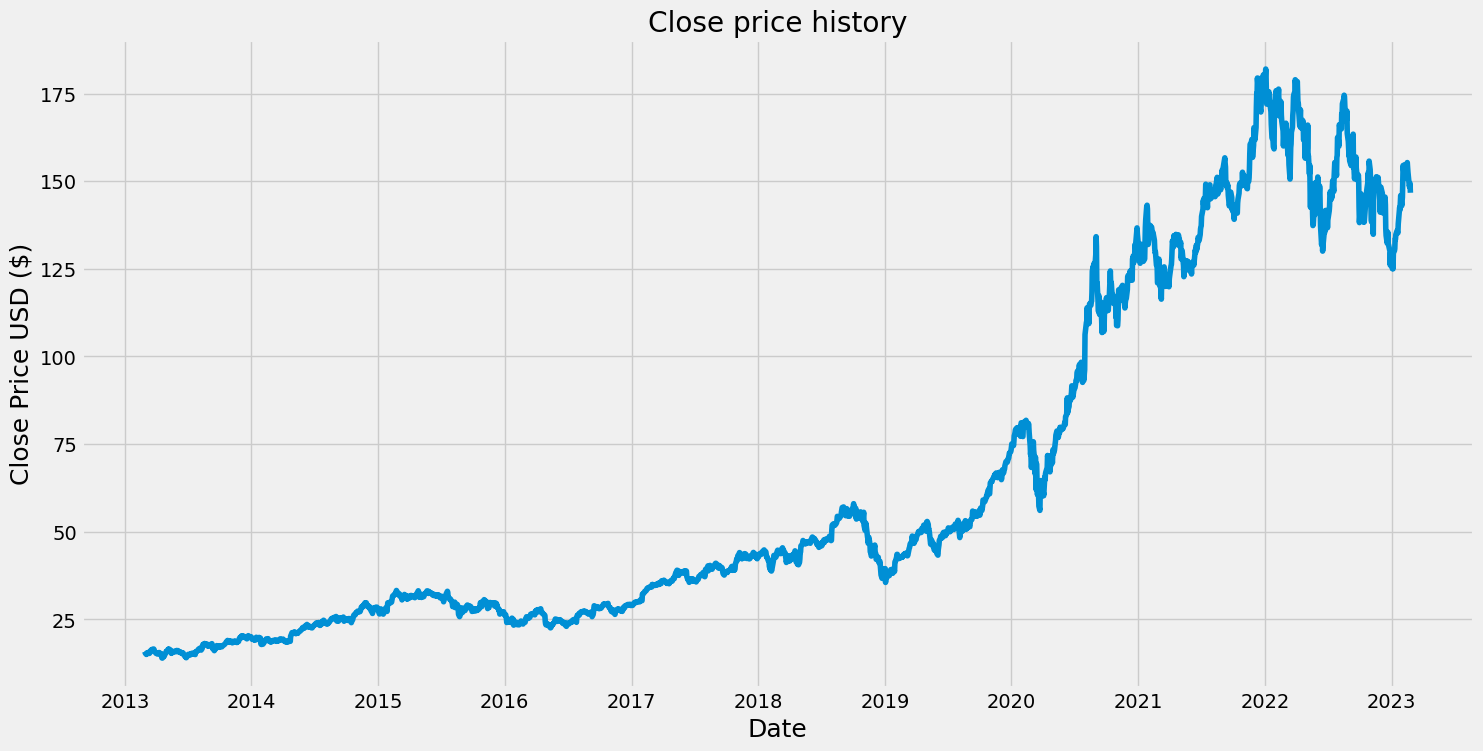

In [18]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title("Close price history")
plt.plot(df["Close"])
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD ($)", fontsize=18)
plt.show()

In [20]:
#Create a new dataframe using only the "Close" column
data = df.filter(["Close"])
#Convert the dataframe to a numpy array
dataset = data.values
#Get the number of rows to train our LSTM model on (80%)
training_data_len = math.ceil(len(dataset) * 0.8)


#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))

#THIS IS NOT THE CORRECT WAY TO DO IT, will fix it in the future
#Should not use fit_transform on the entire dataset, only on the training data !!!
scaled_data = scaler.fit_transform(dataset)
scaled_data


array([[0.01081018],
       [0.00848749],
       [0.00627318],
       ...,
       [0.80304951],
       [0.80596503],
       [0.78995916]])

In [21]:
#In this example we are using the attribute "Close" to predict the next value of "Close"
#We could also use other attributes to predict the next value of "Close"

#Create the training data set
#Create the scaled training data set
train_data = scaled_data[0:training_data_len, :]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0]) #60 previous values (not including i)
    y_train.append(train_data[i, 0]) #The i-th value (the value we want to predict) - i could change it so that it predicts the next n values

#The first value of the first "batch" of x_train is the second value of the second "batch" of x_train and so on ...

In [23]:
#Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [24]:
#Reshape the x_train data set (LSTM expects 3 dimensions - samples, time steps, features)
#Currently we have 2 dimensions - samples, features
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [25]:
#Build the LSTM model which will have 2 LSTM layers and 2 dense layers
model = Sequential()
#First we add the first LSTM layer (50 neurons, return_sequences=True because we are going to add another LSTM layer, because it is the first layer we need to specify the input_shape)
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
#Adding the second LSTM layer (50 neurons, return_sequences=False because it is the last LSTM layer)
model.add(LSTM(50, return_sequences=False))
#Adding the dense layer (25 neurons) (dense layer is a fully connected layer)
model.add(Dense(25))
#Adding the last dense layer (1 neuron because we are predicting the next value of "Close" which is a single value)
model.add(Dense(1))

In [26]:
#Compile the model
#The model optimizer is adam and it used to improve upon the loss function
#The loss function tells us how well the model did on training
model.compile(optimizer="adam", loss="mean_squared_error")

In [27]:
#Train the model
#Batch size is the number of samples per gradient update (if I have 1000 samples and a batch size of 32 it will take 1000/32 iterations to complete 1 epoch)
#Epoch is the number of iterations when an entire dataset is passed forward and backward through the neural network only once
model.fit(x_train, y_train, batch_size=1, epochs=1)

1953/1953 [==============================] - 35s 16ms/step - loss: 9.0412e-04


In [28]:
#Create the testing data set
#Create a new array containing the rest of the values
test_data = scaled_data[training_data_len - 60:, :]
#Create the data sets x_test and y_test
#The values we want to predict are the values after the last 60 values of the training data set
#These values are not scaled
y_test = dataset[training_data_len:, :] 
#For x_test we need to use the scaled values
x_test = []
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [30]:
#Convert the data to a numpy array
x_test = np.array(x_test)

In [31]:
#Reshape the data (LSTM expects 3 dimensions - samples, time steps, features)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [32]:
#Get the models predicted price values
predictions = model.predict(x_test)
#Unscaling the values so that we can compare them with the actual values in the y_test data set which are not scaled
predictions = scaler.inverse_transform(predictions)

16/16 [==============================] - 2s 19ms/step


In [35]:
#Get the root mean squared error (RMSE)
#We subtract the predictions from the actual values and square the result and then we take the mean of the result (to get MSE)
#We then take the square root of the MSE to get RMSE
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

2.813424021301876

C:\Users\zanme\AppData\Local\Temp\ipykernel_8308\3717802802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions #Added the predictions to the testing data set


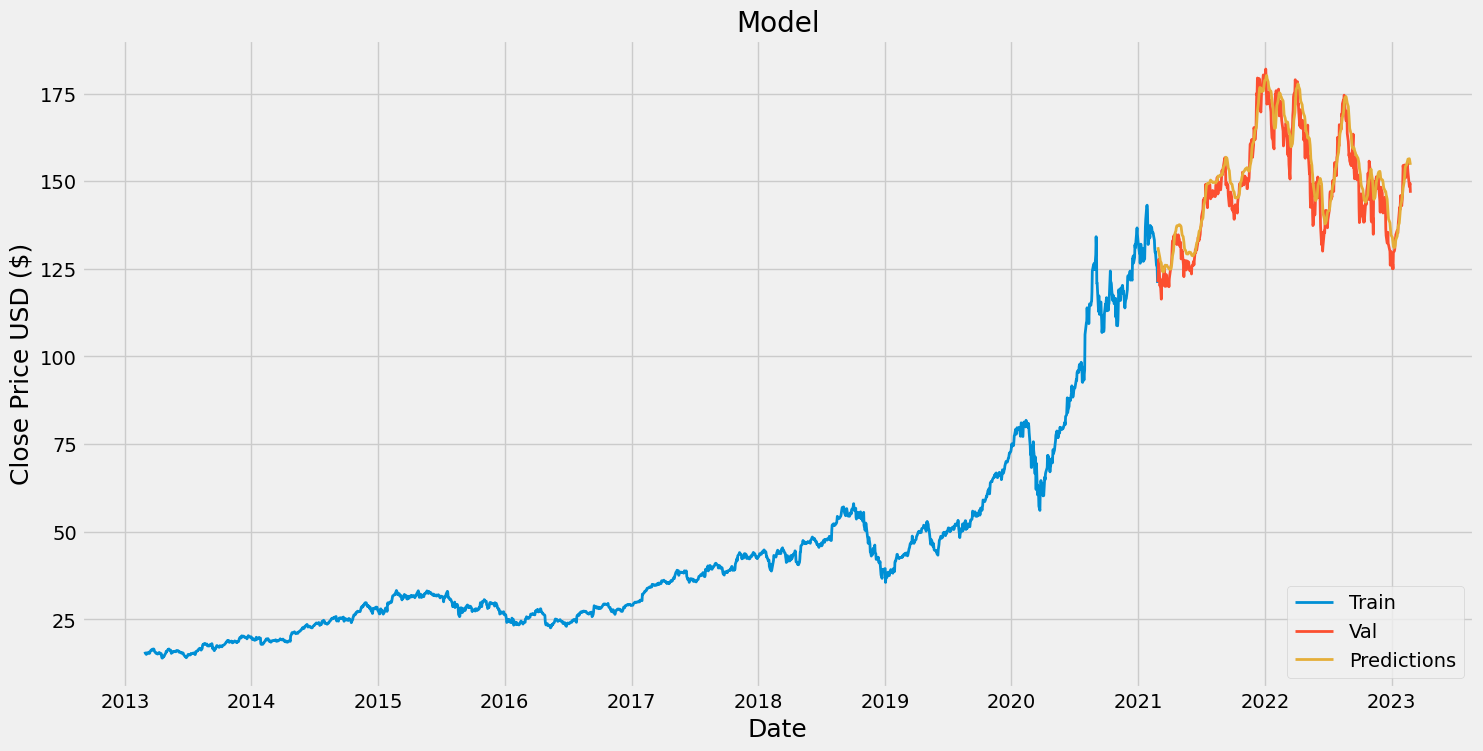

In [39]:
#Plot the data
train = data[:training_data_len] #The first 80% of the data set (training data set)
valid = data[training_data_len:] #The last 20% of the data set (testing data set)
valid["Predictions"] = predictions #Added the predictions to the testing data set
#Visualize the data
plt.figure(figsize=(16,8))
plt.title("Model")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD ($)", fontsize=18)
plt.plot(train["Close"], linewidth=2) #Plot the training data set
plt.plot(valid[["Close", "Predictions"]], linewidth=2) #Plot the testing data set and the predictions
plt.legend(["Train", "Val", "Predictions"], loc="lower right")
plt.show()

In [40]:
#Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2021-02-26,121.260002,131.176834
2021-03-01,127.790001,129.661942
2021-03-02,125.120003,129.029449
2021-03-03,122.059998,128.622406
2021-03-04,120.129997,128.066544
...,...,...
2023-02-17,152.550003,156.307541
2023-02-21,148.479996,156.421646
2023-02-22,148.910004,155.965927


In [47]:
#Try and predict the value of AAPL on a specific date (2020-04-23)
#Get the quote for AAPL until 2020-04-22 so we can use it to predict the value of AAPL on 2020-04-23
df = yf.download("AAPL", start, "2020-04-22")
#Keep only the "Close" column
df = df.filter(["Close"])
#Get the last 60 values of the "Close" column and convert it to a numpy array
last_60_days = df[-60:].values
#Scale the data
#Here we are not using fit_transform because we want to use the same scaler that we used to scale the training data set
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append the last 60 values to the list
X_test.append(last_60_days_scaled)
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data (LSTM expects 3 dimensions - samples, time steps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print("Predicted price for 2020-04-23 is: " + str(pred_price[0][0]))
print("The actual price for 2020-04-23 is: " + str(yf.download("AAPL", "2020-04-20", "2020-04-23")["Close"][-1]))

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 23ms/step
Predicted price for 2020-04-23 is: 71.9363
[*********************100%***********************]  1 of 1 completed
The actual price for 2020-04-23 is: 69.0250015258789
